In [1]:
# local imports
from helpers import *

# pytorch
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# data manipulation
import numpy as np
from os.path import join, exists
from os import mkdir
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import chain

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

In [3]:
DATA_PATH = 'data/'
simulations_file_name = join(DATA_PATH, 'generated_simulations.pt')
anchors_file_name = join(DATA_PATH, 'anchors_pos.pt')

In [4]:
simulations = torch.load(simulations_file_name)
anchors_pos = torch.load(anchors_file_name)

In [5]:
data = SimulationData(simulations, anchors_pos)

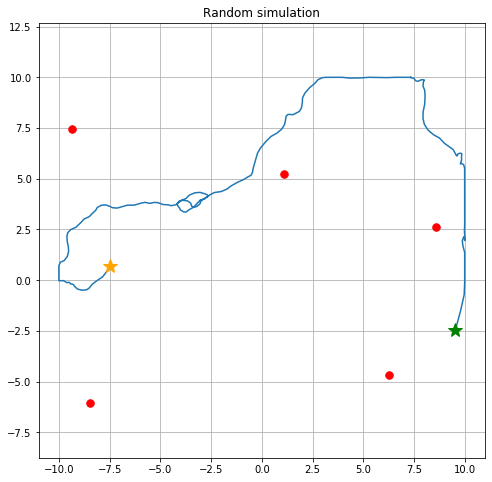

In [51]:
plt.figure(figsize=(8,8))
plt.title("Random simulation")
data.plot_simulation(data[2][1])

In [7]:
BATCH_SIZE = 1
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)

In [17]:
N_EPOCHS = 500

In [9]:
def train_model(model, train_loader, test_loader, nb_epochs, loss_function=nn.MSELoss()):
    """Train a model"""
    
    optimizer = Adam(model.parameters())
    train_losses = []
    test_losses = []

    for _ in range(nb_epochs):
        losses = []
        for batch_input, batch_target in train_loader:
            input = batch_input.view(BATCH_SIZE * N_STEPS, 3 * N_ANCHORS)
            target = batch_target.view(BATCH_SIZE * N_STEPS, 2)
            output = model(input)
            
            loss = loss_function(output, target)
            
            optimizer.zero_grad() # set gradients to zero
            loss.backward() # compute gradient
            optimizer.step() # update weights
            losses.append(loss.item())
            
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        for batch_input, batch_target in test_loader:
            input = batch_input.view(BATCH_SIZE * N_STEPS, 3 * N_ANCHORS)
            target = batch_target.view(BATCH_SIZE * N_STEPS, 2)
            output = model(input)
            
            loss = loss_function(output, target)
            losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [53]:
def plot_loss_evolution(train_losses, test_losses):
    plt.plot(train_losses, c='blue')
    plt.plot(test_losses, c='orange')
    plt.legend(['train loss', 'test loss'])
    plt.ylim(0, 5)
    plt.grid();

In [26]:
n_attr = 3 * N_ANCHORS
n_out = 2

CPU times: user 23.9 s, sys: 300 ms, total: 24.2 s
Wall time: 24 s


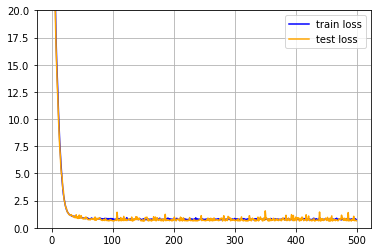

In [27]:
%%time

model = nn.Sequential(
    nn.Linear(n_attr, n_out)
)

train_losses, test_losses = train_model(model, train_loader, test_loader, N_EPOCHS)

plot_loss_evolution(train_losses, test_losses)

In [21]:
pred = model(data[:][0])

In [23]:
def plot_embedding_on_simulation(encoder, data, indices):
    if isinstance(indices, int):
        indices = [indices]
    encoded = encoder(data[indices][0]).detach()
    ground_truth = data[indices][1]

    n_cols = 3
    n_rows = (len(indices) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))
    for idx, (embedding, simulation) in enumerate(zip(encoded, ground_truth)):
        if len(indices) > n_cols:
            ax = axes[idx // n_cols, idx % n_cols]
        else:
            ax = axes[idx % n_cols]
        
        data.plot_simulation(simulation, ax)
        data.plot_simulation(embedding, ax)

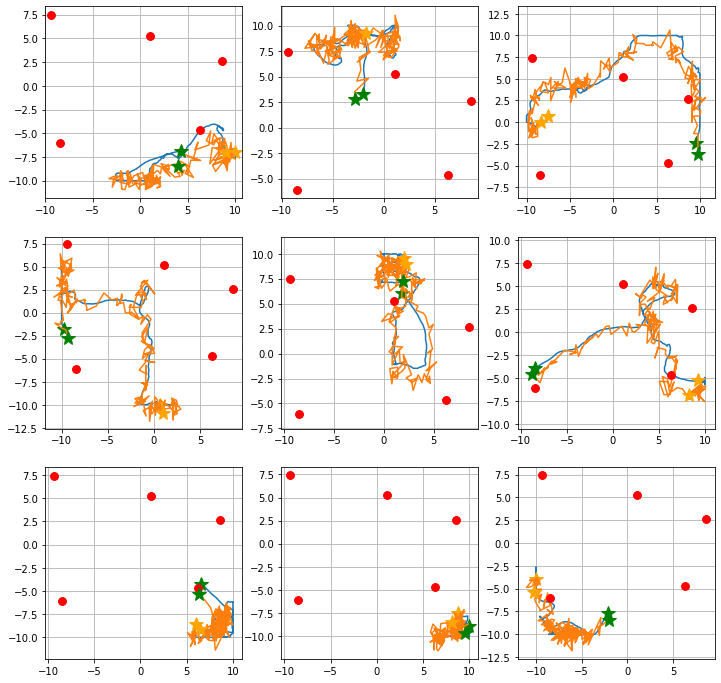

In [24]:

plot_embedding_on_simulation(model, data, range(9))

CPU times: user 39.7 s, sys: 949 ms, total: 40.6 s
Wall time: 40.4 s


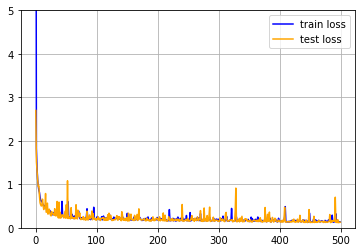

In [83]:
%%time

model = nn.Sequential(
    nn.Linear(n_attr, 16), nn.ReLU(),
    nn.Linear(16, n_out)
)

train_losses, test_losses = train_model(model, train_loader, test_loader, N_EPOCHS)

plot_loss_evolution(train_losses, test_losses)

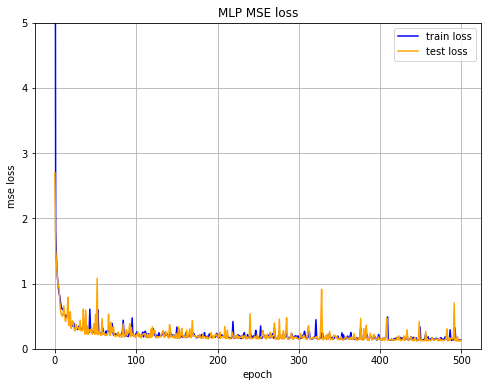

In [84]:
plt.figure(figsize=(8,6))
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.title('MLP MSE loss')
plt.ylim([0,2])
plot_loss_evolution(train_losses, test_losses)

In [85]:
encoded = model(data[:][0])

In [86]:
encoded.size()

torch.Size([200, 200, 2])

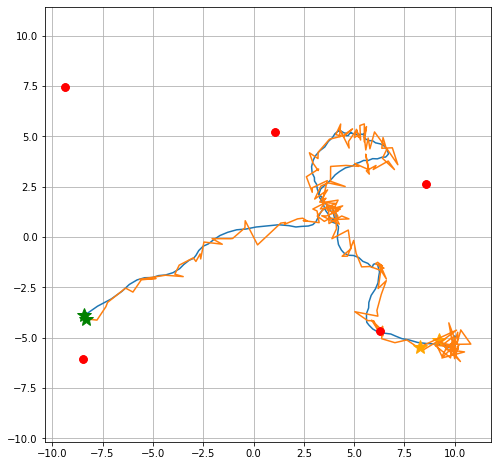

In [87]:
plt.figure(figsize=(8,8))
data.plot_simulation(data[5][1])
data.plot_simulation(encoded[5].detach())

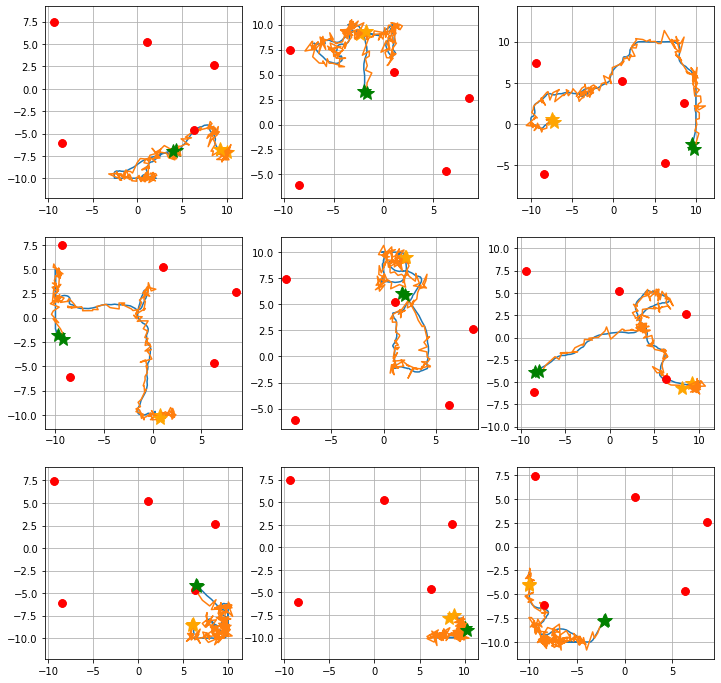

In [30]:
plot_embedding_on_simulation(model, data, range(9))

CPU times: user 5min 49s, sys: 4min 2s, total: 9min 52s
Wall time: 1min 24s


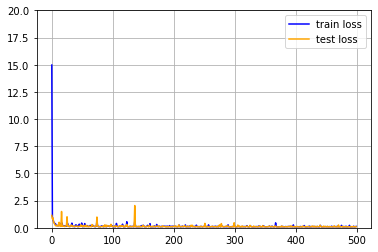

In [32]:
%%time

model = nn.Sequential(
    nn.Linear(n_attr, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, n_out)
)

train_losses, test_losses = train_model(model, train_loader, test_loader, N_EPOCHS)

plot_loss_evolution(train_losses, test_losses)

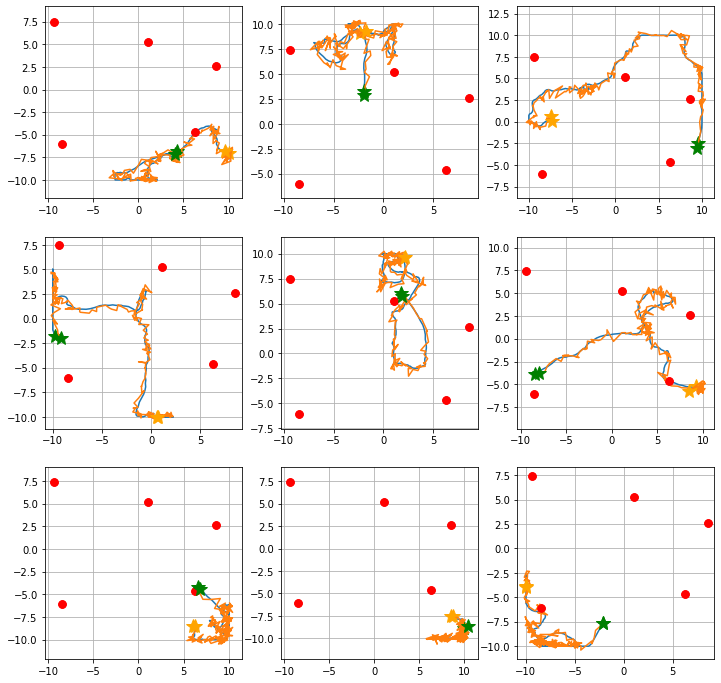

In [33]:
plot_embedding_on_simulation(model, data, range(9))